# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import h5py
import matplotlib.pylab as plt
from math import *
import netCDF4
import xarray as xr
from netCDF4 import date2num,num2date
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from pyproj import Proj, transform

## (2) Read .nc file

### Old version (directly read nc file)

In [4]:
# Enter name of the .nc file
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_w_ibfiltering.nc'

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    print(keys)
    
    # X/Y coordinates and lat/lon on the NSIDC sea ice stereogeographic south
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    
    # Times in seconds from 1800/01/01
    times = np.array(nc.variables['time'])
    t = num2date(nc.variables['time'], nc.variables['time'].units)
    
    # Freeboard statistics
    fmode = np.array(nc.variables['fb_mode'])
    # fmean = np.array(nc.variables['fb_mean'])
    # fmed = np.array(nc.variables['fb_med'])
    fstd = np.array(nc.variables['fb_std'])
    fridge = np.array(nc.variables['fr_ridge'])
    hridge = np.array(nc.variables['h_ridge'])
    # flead = np.array(nc.variables['fr_lead'])
    
    # # Floe statistics
    # # flen = np.array(nc.variables['floe_len'])
    # # fcnt = np.array(nc.variables['floe_cnt'])
    # ibcnt = np.array(nc.variables['ib_cnt'])

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead', 'floe_len', 'floe_cnt', 'ib_cnt'])


In [3]:
# Enter name of the .nc file without iceberg filtering
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_wo_ibfiltering.nc'

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    print(keys)
    
#     # X/Y coordinates and lat/lon on the NSIDC sea ice stereogeographic south
#     x = np.array(nc.variables['x'])
#     y = np.array(nc.variables['y'])
#     xx, yy = np.meshgrid(x, y)
#     lat = np.array(nc.variables['lat'])
#     lon = np.array(nc.variables['lon'])
    
#     # Times in seconds from 1800/01/01
#     times = np.array(nc.variables['time'])
#     t = num2date(nc.variables['time'], nc.variables['time'].units)
    
    # Freeboard statistics
    fmode0 = np.array(nc.variables['fb_mode'])
    # fmean = np.array(nc.variables['fb_mean'])
    # fmed = np.array(nc.variables['fb_med'])
    fstd0 = np.array(nc.variables['fb_std'])
    fridge0 = np.array(nc.variables['fr_ridge'])
    hridge0 = np.array(nc.variables['h_ridge'])
    # flead = np.array(nc.variables['fr_lead'])
    
    # Floe statistics
    # flen = np.array(nc.variables['floe_len'])
    # fcnt = np.array(nc.variables['floe_cnt'])
    # ibcnt = np.array(nc.variables['ib_cnt'])

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead', 'floe_len', 'floe_cnt', 'ib_cnt'])


### New version (read through xarray)

In [3]:
# Enter name of the .nc file
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_w_ibfiltering.nc'
ds = xr.open_dataset(ncname)

ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_wo_ibfiltering.nc'
ds0 = xr.open_dataset(ncname)

In [24]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:   (x: 100, y: 100, time: 5589)
Coordinates:
  * x         (x) float32 400B -2.8e+06 -2.775e+06 ... -3.5e+05 -3.25e+05
  * y         (y) float32 400B 5e+05 5.25e+05 5.5e+05 ... 2.95e+06 2.975e+06
  * time      (time) datetime64[ns] 45kB 2018-10-14T03:12:22 ... 2023-12-27T2...
Data variables:
    lat       (y, x) float64 80kB ...
    lon       (y, x) float64 80kB ...
    fb_mode   (time, x, y) float64 447MB ...
    fb_mean   (time, x, y) float64 447MB ...
    fb_med    (time, x, y) float64 447MB ...
    fb_std    (time, x, y) float64 447MB ...
    fr_ridge  (time, x, y) float64 447MB ...
    h_ridge   (time, x, y) float64 447MB ...
    fr_lead   (time, x, y) float64 447MB ...
    floe_len  (time, x, y) float64 447MB ...
    floe_cnt  (time, x, y) float64 447MB ...
    ib_cnt    (time, x, y) float64 447MB ...

## (3) Draw maps in the Weddell Sea

### Number of landfast ice

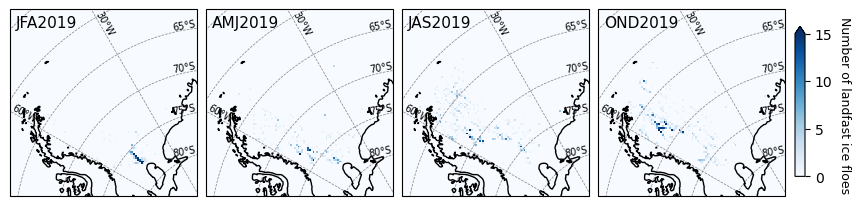

In [65]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0, 'ib_cnt': 0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5, 'ib_cnt': 15}
labels = {'ib_cnt': 'Number of landfast ice floes'}

for field in ['ib_cnt']:
    value = np.array(ds[field])
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 100, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nansum(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field], cmap = "Blues")
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
        
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field], rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\IB_{field}.png", bbox_inches = "tight")

### Dynamic sea ice features

In [15]:
projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

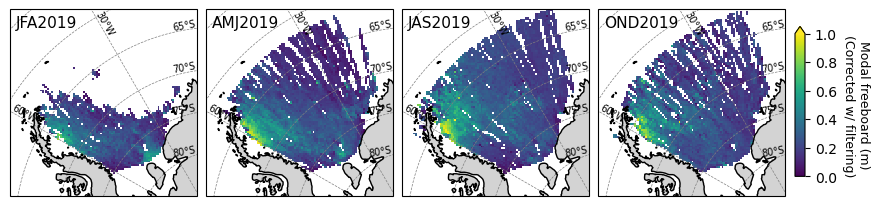

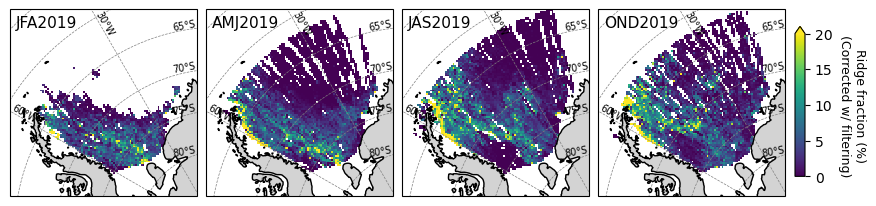

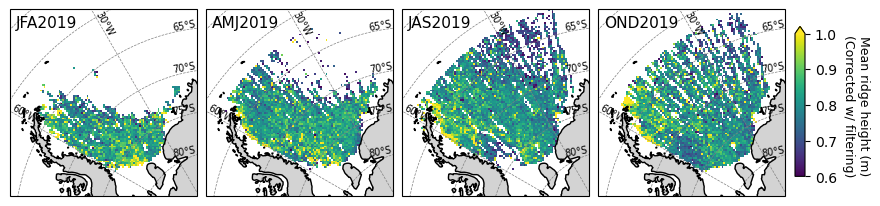

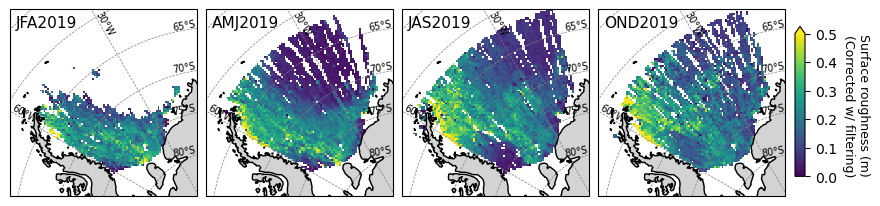

In [59]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.array(ds[field])
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 100, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field])
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
        
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field] + "\n(Corrected w/ filtering)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\IB_Correct_{field}.png", bbox_inches = "tight")

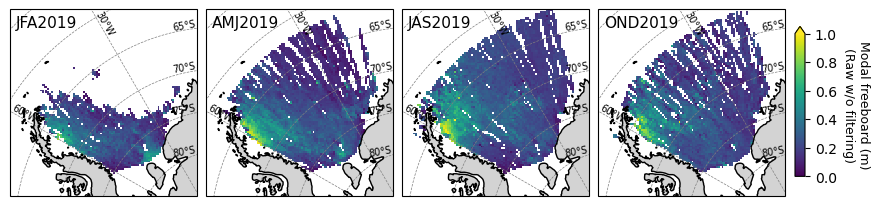

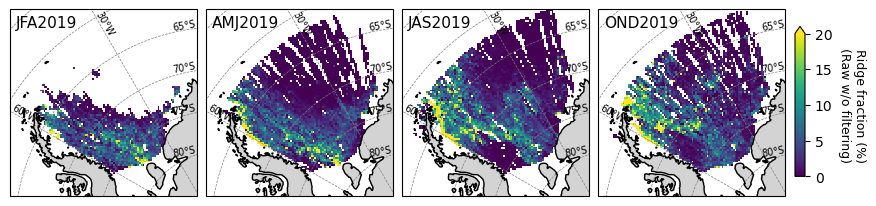

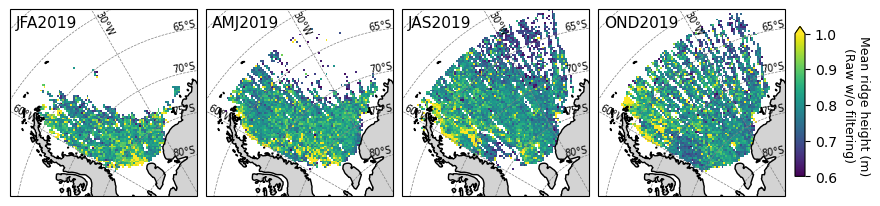

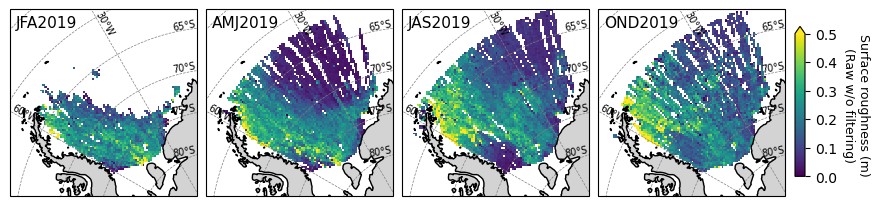

In [61]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.array(ds0[field])
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 100, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.

    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field])
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field] + "\n(Raw w/o filtering)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\IB_Raw_{field}.png", bbox_inches = "tight")

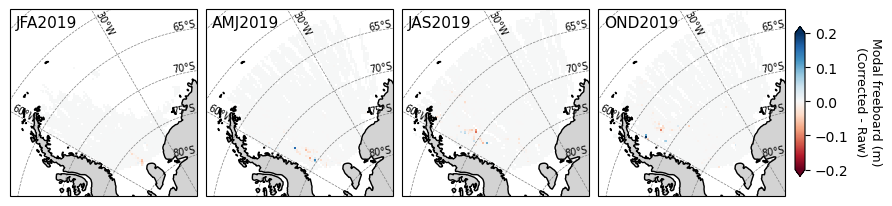

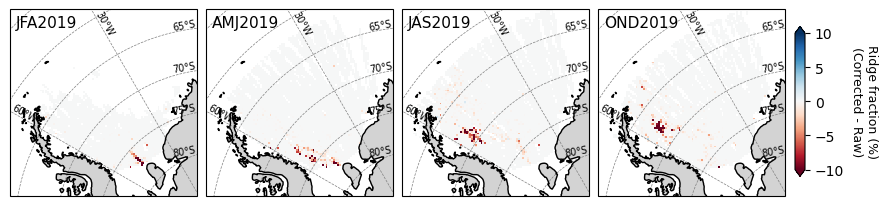

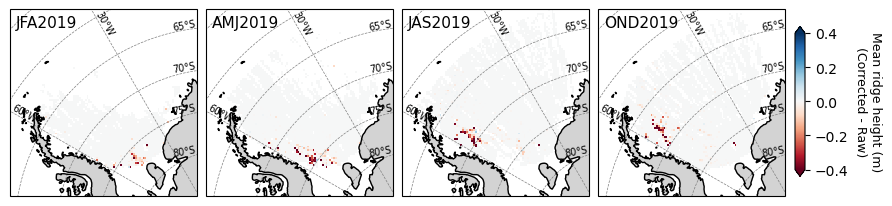

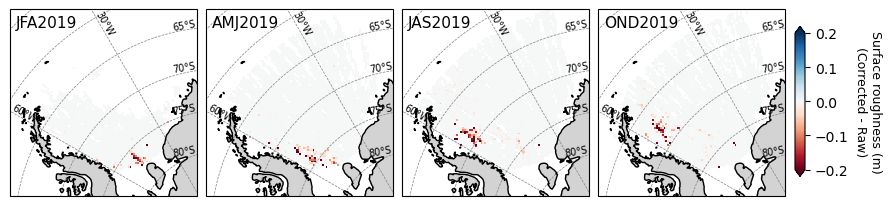

In [56]:
vmin = {'fb_mode':-0.2, 'fr_ridge':-10, 'h_ridge':-0.4, 'fb_std':-0.2}
vmax = {'fb_mode':0.2, 'fr_ridge':10, 'h_ridge':0.4, 'fb_std':0.2}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.array(ds[field]) - np.array(ds0[field])
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 100, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6])
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field], cmap = "RdBu")
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "both")
    cb.set_label(labels[field] + "\n(Corrected - Raw)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\IB_Diff_{field}.png", bbox_inches = "tight")

## Track landfast ice

In [66]:
year = 2019
th_fb = 1.0
th_sigma = 0.02
th_std = 0.08
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_Weddell_2019_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -62]

In [67]:
for i in range(0, len(df_all)):
    df_all.loc[i, "jday"] = int(dt.datetime(df_all.loc[i, "year"], df_all.loc[i, "month"], df_all.loc[i, "day"]).strftime("%j"))

In [69]:
df_all.head(5)

,filename,beam,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width,jday
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2019,1,6,-74.601091,-58.051187,2.839684e+07,40357.0,40441.0,3.382634,3.622471,2.905646,0.162428,467.942822,6.0
1,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2019,1,6,-74.698224,-58.105407,2.840780e+07,41939.0,42027.0,3.714575,4.115487,3.518111,0.135430,479.270515,6.0
2,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,2019,1,6,-74.592652,-58.161481,2.839639e+07,32841.0,32880.0,2.964939,3.092570,2.726331,0.098351,271.383130,6.0
3,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,2019,1,6,-74.691113,-58.217155,2.840750e+07,34142.0,34725.0,3.709136,4.193796,2.850458,0.273464,4092.798666,6.0
4,ATL10-02_20190106142608_01400201_006_02.h5,gt1l,2019,1,6,-76.181920,-53.830477,3.163839e+07,51.0,143.0,2.217194,2.620863,1.873965,0.241777,500.147166,6.0


In [70]:
x, y = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_all['lat'], df_all['lon'])

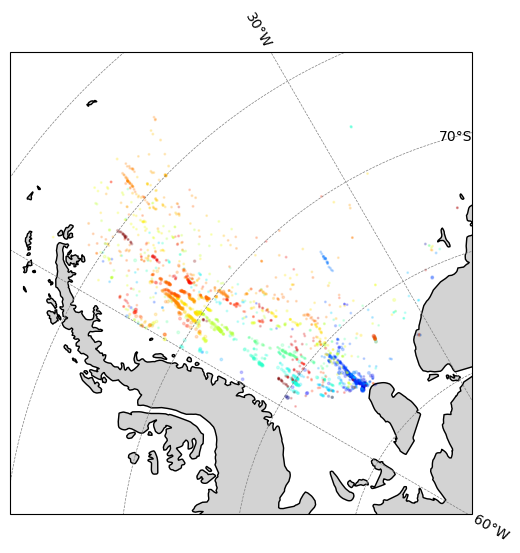

In [74]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                      linewidth=0.5, color='grey', linestyle='--')
    
gl.xlabels_top = True
gl.xlabels_bottom = True
# gl.xlabels_left = True
# gl.xlabels_right = True
gl.ylabels_left = True
gl.ylabels_right = True

ax.coastlines()
# ax.stock_img()
ax.add_feature(cfeature.LAND, color = "lightgray")
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.OCEAN)

width = 2500000
ax.set_xlim(-2800000, -3000000 + width)
ax.set_ylim(300000, 100000 + width)

ax.scatter(x, y, c = df_all['jday'], s = df_all['fb_mean'], alpha = 0.2, cmap = "jet")

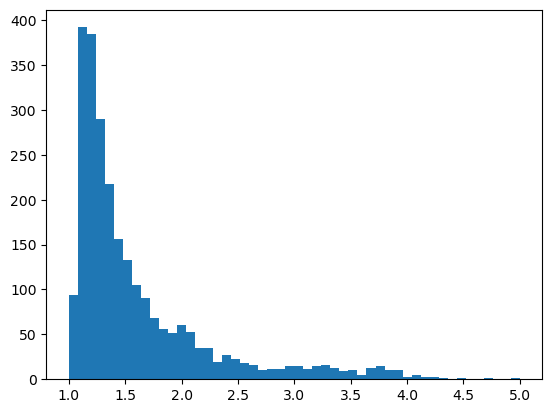

In [79]:
plt.hist(df_all['fb_mean'], range = (1, 5), bins = 50);

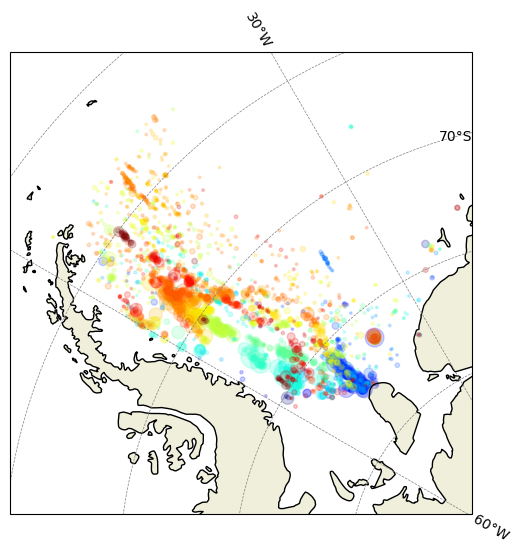

In [58]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                      linewidth=0.5, color='grey', linestyle='--')
    
gl.xlabels_top = True
gl.xlabels_bottom = True
# gl.xlabels_left = True
# gl.xlabels_right = True
gl.ylabels_left = True
gl.ylabels_right = True

ax.coastlines()
# ax.stock_img()
ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.OCEAN)

width = 2500000
ax.set_xlim(-2800000, -3000000 + width)
ax.set_ylim(300000, 100000 + width)

ax.scatter(x, y, c = df_all['jday'], s = df_all['width']/50, alpha = 0.2, cmap = "jet")

## Sensitivity analysis

In [79]:
region = "Weddell"

sigmas = [0.02, 0.018, 0.016, 0.014]
stds = [0.1, 0.08, 0.06, 0.04]

count_points = np.zeros((len(sigmas), len(stds)))

for year in [2019]:

    th_fb = 1.0
    
    for i, th_sigma in enumerate(sigmas):
        for j, th_std in enumerate(stds):

            df = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)
            
            for k in range(0, len(df)):
                count_points[i,j] += df.loc[k, 'id_en'] - df.loc[k, 'id_st'] + 1


Text(0.5, 0, 'Std. of Freeboard')

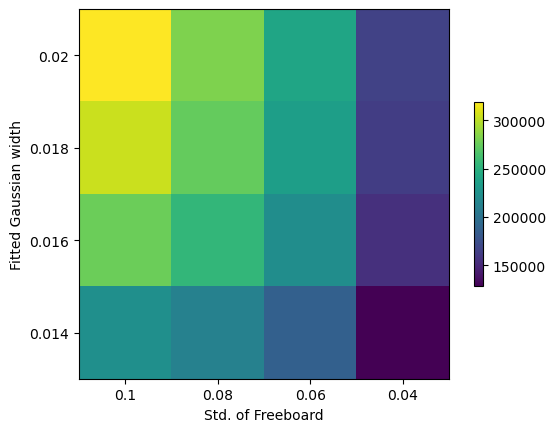

In [85]:
plt.imshow(count_points)
plt.xticks(range(0, len(stds)), stds)
plt.yticks(range(0, len(sigmas)), sigmas)
plt.colorbar(shrink = 0.5)
plt.ylabel('Fitted Gaussian width')
plt.xlabel('Std. of Freeboard')

In [89]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba) 

(0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)


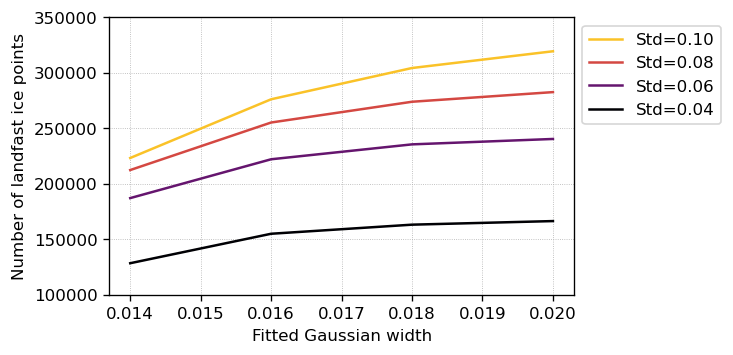

In [131]:
cmap = matplotlib.cm.get_cmap('inferno')

plt.figure(figsize = (5,3), dpi = 120)
for j, th_std in enumerate(stds):
    color = cmap((th_std - min(stds))/(max(stds) - min(stds)+0.01))
    plt.plot(sigmas, count_points[:, j], label = f"Std={th_std:.2f}", color = color)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Number of landfast ice points')
plt.xlabel('Fitted Gaussian width')
plt.grid(ls = ":", lw = 0.5)
plt.ylim(100000, 350000)
plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\Fig07.png", bbox_inches = "tight")

In [ ]:
count_points = 0

for i in range(0, len(df_ib2)):
    count_points += df_ib2.loc[i, 'id_en'] - df_ib2.loc[i, 'id_st'] + 1

## Compare Iceberg and Sea ice features

In [2]:
import glob
from functions_floes import *

In [3]:
bbox = [-65, -77.6, -15, -62]

In [8]:
ib_files = glob.glob("D:\\Floes\\icebergs\\csvfiles\\*ib.csv")
ib_files

first = True

for f in ib_files:
    df_ib0 = pd.read_csv(f)

    df_ib0['fb_std'] = pd.Series(df_ib0['fb']).rolling(3, center = True).std().values
    beam = f[-11:-7]
    filename = "D:\\Floes\\ATL10\\{0}".format(os.path.basename(f)[:-12] + ".h5")
    df_raw = read_ATL10(filename, bbox)

    # for i in range(len(df_ib0)):
    #     try:
    #         df_ib0.loc[i, "fb_std"] = df_raw[df_raw['lon'] == df_ib0.loc[i, "lon"]]["fb_std"].values[0]
    #     except:
    #         df_ib0.loc[i, "fb_std"] = np.nan
    # df_raw = df_raw[(df_raw['beam'] == beam)]
    
    if first:
        df_ib = df_ib0
        first = False
    else:
        df_ib = pd.concat([df_ib, df_ib0], ignore_index = True)

In [9]:
si_files = glob.glob("D:\\Floes\\icebergs\\csvfiles\\*si.csv")
si_files

first = True

for f in si_files:
    df_si0 = pd.read_csv(f)
    df_si0['fb_std'] = pd.Series(df_si0['fb']).rolling(3, center = True).std().values

    # for i in range(len(df_si0)):
    #     try:
    #         df_si0.loc[i, "fb_std"] = df_raw[df_raw['lon'] == df_si0.loc[i, "lon"]]["fb_std"].values[0]
    #     except:
    #         df_si0.loc[i, "fb_std"] = np.nan
    
    if first:
        df_si = df_si0
        first = False
    else:
        df_si = pd.concat([df_si, df_si0], ignore_index = True)

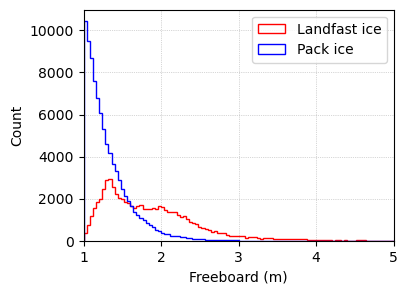

In [10]:
field = 'fb'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (1, 5), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (1, 5), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.015, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Freeboard (m)")
plt.legend()
plt.xlim(1,5)
plt.grid(ls = ":", lw = 0.5)

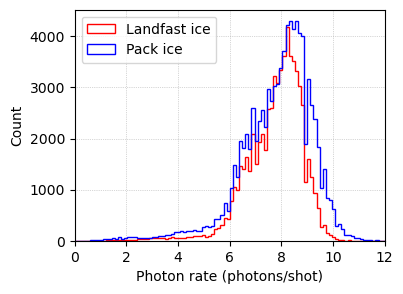

In [11]:
field = 'ph_rate'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 12), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 12), histtype="step", density = False, label = "Pack ice");
# plt.axvline(0.015, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Photon rate (photons/shot)")
plt.legend()
plt.xlim(0,12)
plt.grid(ls = ":", lw = 0.5)

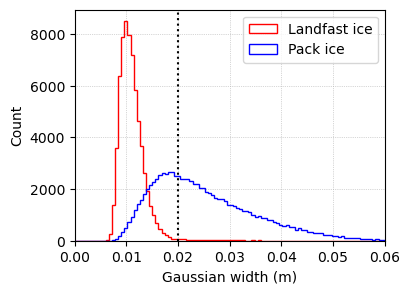

In [12]:
field = 'sigma'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 0.06), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 0.06), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.02, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Gaussian width (m)")
plt.legend()
plt.xlim(0,0.06)
plt.grid(ls = ":", lw = 0.5)

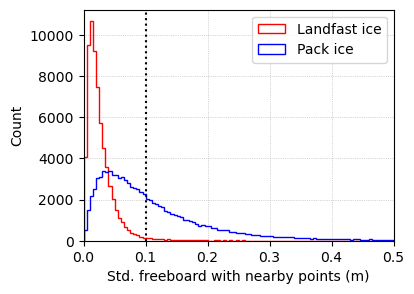

In [13]:
field = 'fb_std'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 0.5), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 0.5), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.1, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Std. freeboard with nearby points (m)")
plt.legend()
plt.xlim(0,0.5)
plt.grid(ls = ":", lw = 0.5)